*(notebook fait sur kaggle)*

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nli-prof/nli_fr_test.tsv
/kaggle/input/nli-prof/nli_fr_train.tsv


# Natural Language Inference en Français avec CamemBERT et LoRA

**Projet MIASHS M2 - Representation Learning**

---

## Objectif

Ce notebook implémente un système de **Natural Language Inference (NLI)** pour le français. Étant donné une paire de phrases (prémisse, hypothèse), le modèle prédit la relation sémantique entre elles :

| Relation | Description | Exemple |
|----------|-------------|----------|
| **Entailment** (Conséquence) | L'hypothèse découle logiquement de la prémisse | P: "Le chat dort sur le canapé" → H: "Un animal est sur un meuble" |
| **Contradiction** | L'hypothèse contredit la prémisse | P: "Le chat dort sur le canapé" → H: "Le chat court dehors" |
| **Neutral** | Aucune relation logique claire | P: "Le chat dort sur le canapé" → H: "Le chat aime le poisson" |

## Méthodologie

Nous comparons deux encodeurs pré-entraînés sur le français :
- **CamemBERT-base** (architecture RoBERTa)
- **CamemBERTa-base** (architecture DeBERTa-v2)

Les modèles sont fine-tunés avec **LoRA** (Low-Rank Adaptation) pour une efficacité paramétrique optimale.

---

## 1. Installation et Configuration

In [1]:
!pip install -q polars transformers accelerate peft bitsandbytes sentencepiece evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 34.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00


In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import torch.nn as nn
import numpy as np
import polars as pl
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback
)
from peft import get_peft_model, LoraConfig, TaskType
import peft
import transformers
import evaluate
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reproductibilité
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"PEFT version: {peft.__version__}")
print(f"Polars version: {pl.__version__}")
print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

2026-01-03 20:44:37.010227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767473077.209775      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767473077.263803      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767473077.741912      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767473077.741948      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767473077.741951      55 computation_placer.cc:177] computation placer alr

PyTorch version: 2.8.0+cu126
Transformers version: 4.57.1
PEFT version: 0.17.1
Polars version: 1.25.2
GPU disponible: True
GPU: Tesla T4


---

## 2. Chargement et Exploration des Données

In [43]:
# Chemins des fichiers
TRAIN_FILE = "/kaggle/input/nli-prof/nli_fr_train.tsv" 
TEST_FILE = "/kaggle/input/nli-prof/nli_fr_test.tsv"

# Chargement avec Polars
print("Chargement des données avec Polars...")
train_df = pl.read_csv(TRAIN_FILE, separator="\t")
test_df = pl.read_csv(TEST_FILE, separator="\t")

print(f"\n Dimensions:")
print(f"  Train: {train_df.shape[0]} exemples, {train_df.shape[1]} colonnes")
print(f"  Test: {test_df.shape[0]} exemples, {test_df.shape[1]} colonnes")

print(f"Colonnes: {train_df.columns}")

Chargement des données avec Polars...

 Dimensions:
  Train: 5010 exemples, 3 colonnes
  Test: 2490 exemples, 3 colonnes
Colonnes: ['-e premise', 'hypo', 'label']


In [4]:
# Aperçu des données
print("Aperçu des données:")
train_df.head()

Aperçu des données:


-e premise,hypo,label
str,str,str
"""Eh bien, je ne pensais même pa…","""Je ne lui ai pas parlé de nouv…","""contradiction"""
"""Eh bien, je ne pensais même pa…","""J'étais si contrarié que je co…","""entailment"""
"""Eh bien, je ne pensais même pa…","""Nous avons eu une grande discu…","""neutral"""
"""Et je pensais que c'était un p…","""Je n'avais pas conscience que …","""neutral"""
"""Et je pensais que c'était un p…","""J'avais l'impression que j'éta…","""entailment"""


In [5]:
PREMISE_COL = "-e premise"  
HYPOTHESIS_COL = "hypo"       
LABEL_COL = "label"          

# Vérification
print("Vérification des colonnes:")
print(f"  Prémisse ({PREMISE_COL}): {train_df[PREMISE_COL][0]}")
print(f"  Hypothèse ({HYPOTHESIS_COL}): {train_df[HYPOTHESIS_COL][0]}")
print(f"  Label ({LABEL_COL}): {train_df[LABEL_COL][0]}")

Vérification des colonnes:
  Prémisse (-e premise): Eh bien, je ne pensais même pas à cela, mais j'étais si frustré, et j'ai fini par lui reparler.
  Hypothèse (hypo): Je ne lui ai pas parlé de nouveau
  Label (label): contradiction



 Distribution des labels:
shape: (3, 2)
┌───────────────┬──────┐
│ label         ┆ len  │
│ ---           ┆ ---  │
│ str           ┆ u32  │
╞═══════════════╪══════╡
│ entailment    ┆ 1670 │
│ neutral       ┆ 1670 │
│ contradiction ┆ 1670 │
└───────────────┴──────┘


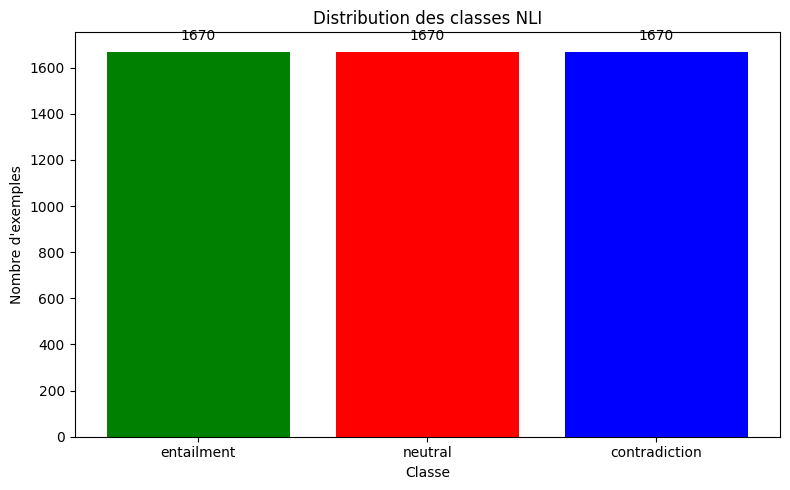

In [42]:
# Distribution des labels
print("\n Distribution des labels:")
label_counts = train_df.group_by(LABEL_COL).len().sort("len", descending=True)
print(label_counts)

# Visualisation
fig, ax = plt.subplots(figsize=(8, 5))
labels = label_counts[LABEL_COL].to_list()
counts = label_counts["len"].to_list()
colors = ['green', 'red', 'blue']
ax.bar(labels, counts, color=colors[:len(labels)])
ax.set_title('Distribution des classes NLI')
ax.set_xlabel('Classe')
ax.set_ylabel('Nombre d\'exemples')
for i, (label, count) in enumerate(zip(labels, counts)):
    ax.text(i, count + 50, str(count), ha='center', fontsize=10)
plt.tight_layout()
plt.show()

---

## 3. Configuration et Dataset PyTorch

In [7]:
# Mapping des labels
LABEL2ID = {"entailment": 0, "neutral": 1, "contradiction": 2}
ID2LABEL = {0: "entailment", 1: "neutral", 2: "contradiction"}
NUM_LABELS = 3

# Hyperparamètres
MAX_LENGTH = 128
BATCH_SIZE = 32
LEARNING_RATE = 2e-4
NUM_EPOCHS = 10
WEIGHT_DECAY = 0.01

# Configuration LoRA
LORA_R = 8
LORA_ALPHA = 32
LORA_DROPOUT = 0.1

print("Configuration définie")

Configuration définie


In [8]:
class NLIDataset(Dataset):
    """
    Dataset PyTorch pour NLI.
    
    Remplace HuggingFace datasets (incompatible avec pyarrow).
    Charge les données via Polars et tokenize.
    """
    
    def __init__(self, df: pl.DataFrame, tokenizer, max_length: int = 128):
        # Extraction des données en listes Python (plus rapide que accès DataFrame)
        self.premises = df[PREMISE_COL].to_list()
        self.hypotheses = df[HYPOTHESIS_COL].to_list()
        self.labels = df[LABEL_COL].to_list()
        
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.premises[idx],
            self.hypotheses[idx],
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        
        # Conversion du label
        label = self.labels[idx]
        if isinstance(label, str):
            label = LABEL2ID[label]
        
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }


print("Classe NLIDataset définie")

Classe NLIDataset définie


---

## 4. Fonctions Utilitaires

In [9]:
# Charger les métriques
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    """
    Calcule accuracy et F1 scores.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1_macro = f1_metric.compute(predictions=predictions, references=labels, average="macro")
    f1_weighted = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    
    return {
        "accuracy": acc["accuracy"],
        "f1_macro": f1_macro["f1"],
        "f1_weighted": f1_weighted["f1"]
    }


def plot_confusion_matrix(trainer, eval_dataset, class_names):
    """
    Affiche la matrice de confusion.
    """
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    labels = predictions.label_ids
    
    cm = confusion_matrix(labels, preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité')
    plt.title('Matrice de Confusion')
    plt.tight_layout()
    plt.show()
    
    print("\n Rapport de classification:")
    print(classification_report(labels, preds, target_names=class_names))


def plot_training_history(log_history):
    """
    Visualise l'évolution de la loss et des métriques.
    """
    train_loss = [x['loss'] for x in log_history if 'loss' in x]
    eval_data = [x for x in log_history if 'eval_loss' in x]
    eval_loss = [x['eval_loss'] for x in eval_data]
    eval_acc = [x['eval_accuracy'] for x in eval_data]
    eval_f1 = [x.get('eval_f1_macro', 0) for x in eval_data]
    epochs = list(range(1, len(eval_loss) + 1))
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss
    axes[0].plot(epochs, eval_loss, 'b-o', label='Eval Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Évolution de la Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(epochs, eval_acc, 'g-o', label='Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Évolution de l\'Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[2].plot(epochs, eval_f1, 'r-o', label='F1 Macro')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_title('Évolution du F1 Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("Fonctions utilitaires définies")

Fonctions utilitaires définies


---

## 5. Modèle 1 : CamemBERT-base + LoRA

CamemBERT est basé sur l'architecture **RoBERTa**, pré-entraîné sur un corpus français de 138 Go (OSCAR).

### 5.1 Préparation

In [10]:
MODEL_1_NAME = "almanach/camembert-base"

print(f"Chargement du tokenizer {MODEL_1_NAME}...")
tokenizer_1 = AutoTokenizer.from_pretrained(MODEL_1_NAME)

print("Création des datasets...")
train_dataset_1 = NLIDataset(train_df, tokenizer_1, MAX_LENGTH)
test_dataset_1 = NLIDataset(test_df, tokenizer_1, MAX_LENGTH)

print(f"Train: {len(train_dataset_1)} exemples")
print(f"Test: {len(test_dataset_1)} exemples")

Chargement du tokenizer almanach/camembert-base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Création des datasets...
Train: 5010 exemples
Test: 2490 exemples


In [11]:
# Vérification d'un exemple
sample = train_dataset_1[0]
print("Exemple tokenisé:")
print(f"  input_ids shape: {sample['input_ids'].shape}")
print(f"  attention_mask shape: {sample['attention_mask'].shape}")
print(f"  label: {sample['labels']} ({ID2LABEL[sample['labels'].item()]})")

Exemple tokenisé:
  input_ids shape: torch.Size([128])
  attention_mask shape: torch.Size([128])
  label: 2 (contradiction)


### 5.2 Modèle et LoRA

In [12]:
print(f"Chargement du modèle {MODEL_1_NAME}...")
model_1 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_1_NAME, 
    num_labels=NUM_LABELS, 
    id2label=ID2LABEL, 
    label2id=LABEL2ID
)

# Configuration LoRA pour CamemBERT (architecture RoBERTa)
lora_config_1 = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=["query", "value"]  # Architecture RoBERTa
)

model_1 = get_peft_model(model_1, lora_config_1)

print("\nParamètres entraînables:")
model_1.print_trainable_parameters()

Chargement du modèle almanach/camembert-base...


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at almanach/camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Paramètres entraînables:
trainable params: 887,811 || all params: 111,512,070 || trainable%: 0.7962


### 5.3 Entraînement

In [13]:
training_args_1 = TrainingArguments(
    output_dir="./results_camembert",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    seed=SEED,
    report_to="none",
    dataloader_num_workers=2,
)

trainer_1 = Trainer(
    model=model_1,
    args=training_args_1,
    train_dataset=train_dataset_1,
    eval_dataset=test_dataset_1,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Trainer configuré")

Trainer configuré


In [14]:
print("Lancement de l'entraînement CamemBERT + LoRA...")
print("="*60)
trainer_1.train()

Lancement de l'entraînement CamemBERT + LoRA...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.098800,1.061608,0.477912,0.461629,0.461629
2,0.903400,0.855937,0.627711,0.622663,0.622663
3,0.820000,0.752114,0.683133,0.684589,0.684589
4,0.689600,0.716517,0.702811,0.701995,0.701995
5,0.689100,0.698081,0.708032,0.708245,0.708245
6,0.640500,0.696902,0.715663,0.716612,0.716612
7,0.619200,0.673548,0.722088,0.722190,0.722190
8,0.602900,0.669667,0.725301,0.725006,0.725006
9,0.575600,0.677446,0.726908,0.726273,0.726273
10,0.569100,0.673848,0.727309,0.727253,0.727253


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=790, training_loss=0.717345510555219, metrics={'train_runtime': 550.8198, 'train_samples_per_second': 90.955, 'train_steps_per_second': 1.434, 'total_flos': 3329655683328000.0, 'train_loss': 0.717345510555219, 'epoch': 10.0})

### 5.4 Évaluation

In [ ]:
print("Évaluation finale CamemBERT:")
results_1 = trainer_1.evaluate()
print(f"  Accuracy: {results_1['eval_accuracy']:.4f}")
print(f"  F1 Macro: {results_1['eval_f1_macro']:.4f}")
print(f"  F1 Weighted: {results_1['eval_f1_weighted']:.4f}")
print(f"  Loss: {results_1['eval_loss']:.4f}")


 Évaluation finale CamemBERT:


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


  Accuracy: 0.7273
  F1 Macro: 0.7273
  F1 Weighted: 0.7273
  Loss: 0.6738


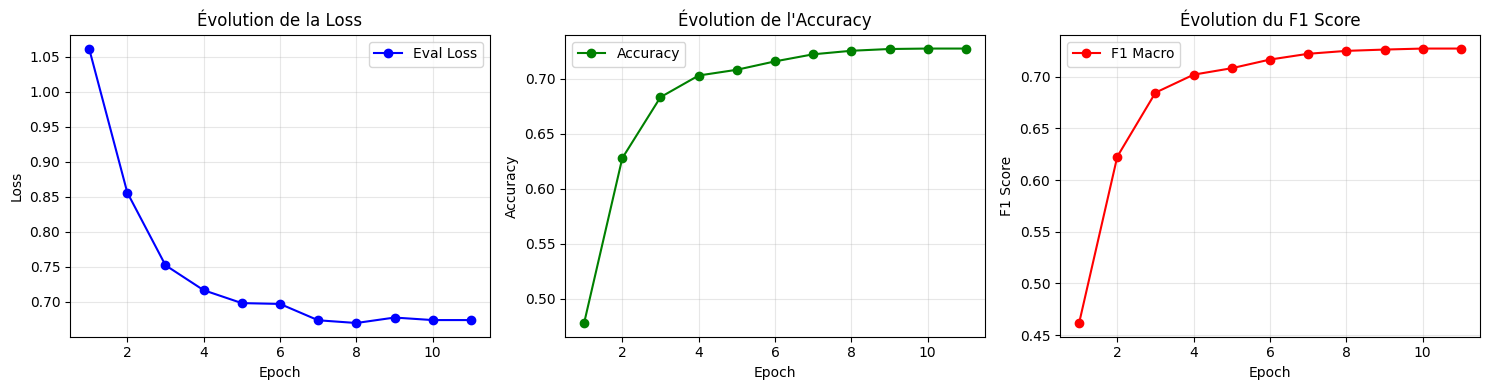

In [16]:
# Visualisations
plot_training_history(trainer_1.state.log_history)

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


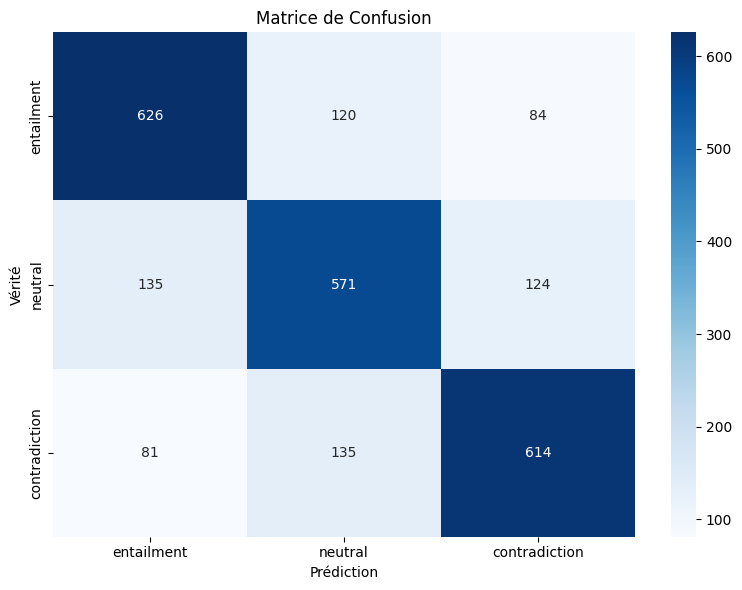


 Rapport de classification:
               precision    recall  f1-score   support

   entailment       0.74      0.75      0.75       830
      neutral       0.69      0.69      0.69       830
contradiction       0.75      0.74      0.74       830

     accuracy                           0.73      2490
    macro avg       0.73      0.73      0.73      2490
 weighted avg       0.73      0.73      0.73      2490



In [17]:
plot_confusion_matrix(trainer_1, test_dataset_1, list(LABEL2ID.keys()))

---

## 6. Modèle 2 : CamemBERTa-base + LoRA

CamemBERTa est basé sur l'architecture **DeBERTa-v2**, qui intègre des améliorations comme le *disentangled attention* et un *enhanced mask decoder*.

### 6.1 Préparation

In [18]:
MODEL_2_NAME = "almanach/camemberta-base"

print(f"Chargement du tokenizer {MODEL_2_NAME}...")
tokenizer_2 = AutoTokenizer.from_pretrained(MODEL_2_NAME)

print("Création des datasets...")
train_dataset_2 = NLIDataset(train_df, tokenizer_2, MAX_LENGTH)
test_dataset_2 = NLIDataset(test_df, tokenizer_2, MAX_LENGTH)

print(f"Train: {len(train_dataset_2)} exemples")
print(f"Test: {len(test_dataset_2)} exemples")

Chargement du tokenizer almanach/camemberta-base...


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/809k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/32.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Création des datasets...
Train: 5010 exemples
Test: 2490 exemples


### 6.2 Modèle et LoRA

In [19]:
print(f"Chargement du modèle {MODEL_2_NAME}...")
model_2 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_2_NAME, 
    num_labels=NUM_LABELS, 
    id2label=ID2LABEL, 
    label2id=LABEL2ID
)

# Configuration LoRA pour CamemBERTa (architecture DeBERTa-v2)
# Les modules d'attention utilisent "query_proj" et "value_proj"
lora_config_2 = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=["query_proj", "value_proj"]  # Architecture DeBERTa
)

model_2 = get_peft_model(model_2, lora_config_2)

print("Paramètres entraînables:")
model_2.print_trainable_parameters()

Chargement du modèle almanach/camemberta-base...


config.json:   0%|          | 0.00/979 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at almanach/camemberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Paramètres entraînables:
trainable params: 297,219 || all params: 112,694,790 || trainable%: 0.2637


### 6.3 Entraînement

In [26]:
training_args_2 = TrainingArguments(
    output_dir="./results_camemberta",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    seed=SEED,
    report_to="none",
    dataloader_num_workers=2,
)

trainer_2 = Trainer(
    model=model_2,
    args=training_args_2,
    train_dataset=train_dataset_2,
    eval_dataset=test_dataset_2,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Trainer configuré")

Trainer configuré


In [28]:
print("Lancement de l'entraînement CamemBERTa + LoRA...")
print("="*60)
trainer_2.train()

Lancement de l'entraînement CamemBERTa + LoRA...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.557500,0.658140,0.745382,0.745339,0.745339
2,0.510700,0.674224,0.742972,0.745167,0.745167
3,0.503500,0.668465,0.746988,0.747546,0.747546
4,0.447900,0.671951,0.751406,0.751980,0.751980
5,0.463500,0.680016,0.751406,0.751947,0.751947
6,0.429000,0.684580,0.757430,0.758561,0.758561
7,0.415100,0.691765,0.752209,0.753595,0.753595
8,0.392800,0.682794,0.758635,0.758241,0.758241
9,0.394200,0.685266,0.759438,0.759293,0.759293
10,0.384300,0.685278,0.759839,0.759802,0.759802


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=790, training_loss=0.4492081907731068, metrics={'train_runtime': 738.4261, 'train_samples_per_second': 67.847, 'train_steps_per_second': 1.07, 'total_flos': 3375162964224000.0, 'train_loss': 0.4492081907731068, 'epoch': 10.0})

### 6.4 Évaluation

In [29]:
print("Évaluation finale CamemBERTa:")
results_2 = trainer_2.evaluate()
print(f"  Accuracy: {results_2['eval_accuracy']:.4f}")
print(f"  F1 Macro: {results_2['eval_f1_macro']:.4f}")
print(f"  F1 Weighted: {results_2['eval_f1_weighted']:.4f}")
print(f"  Loss: {results_2['eval_loss']:.4f}")

Évaluation finale CamemBERTa:


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


  Accuracy: 0.7598
  F1 Macro: 0.7598
  F1 Weighted: 0.7598
  Loss: 0.6853


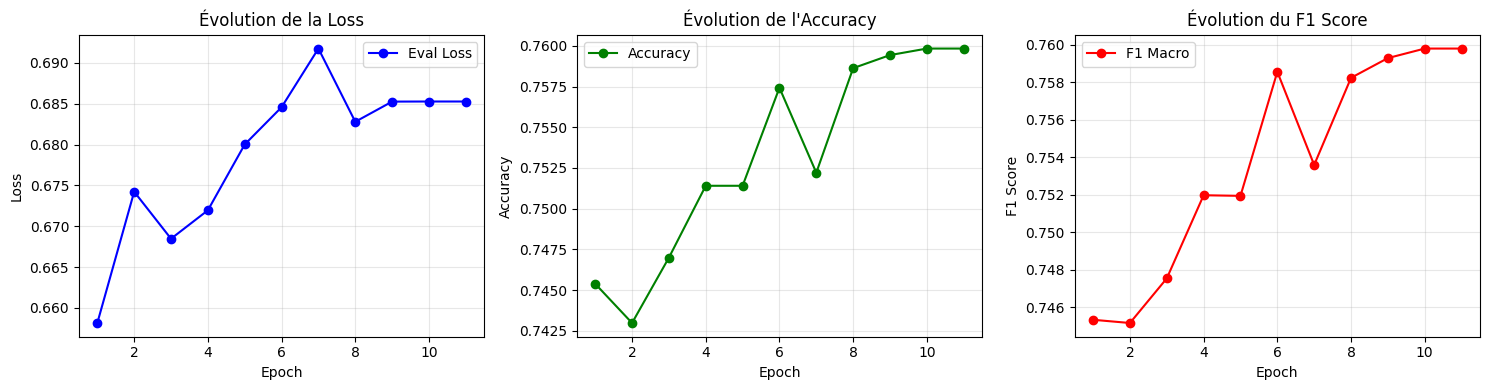

In [30]:
plot_training_history(trainer_2.state.log_history)

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


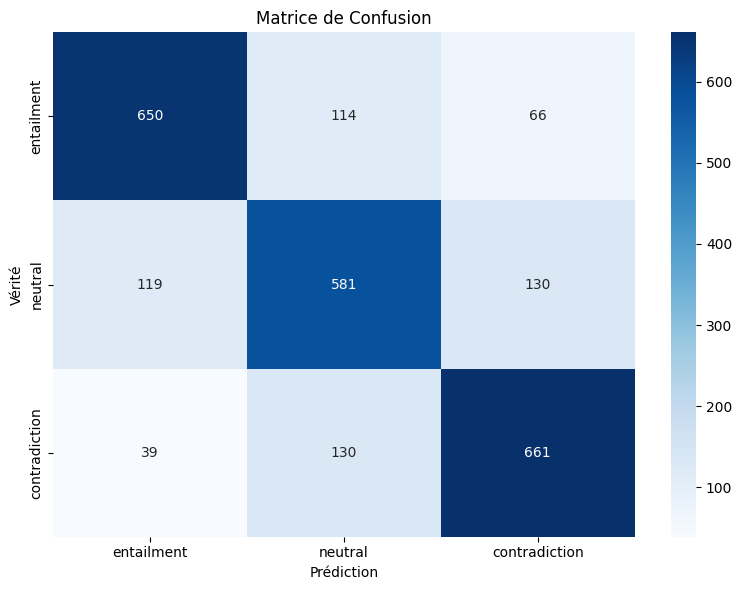


 Rapport de classification:
               precision    recall  f1-score   support

   entailment       0.80      0.78      0.79       830
      neutral       0.70      0.70      0.70       830
contradiction       0.77      0.80      0.78       830

     accuracy                           0.76      2490
    macro avg       0.76      0.76      0.76      2490
 weighted avg       0.76      0.76      0.76      2490



In [31]:
plot_confusion_matrix(trainer_2, test_dataset_2, list(LABEL2ID.keys()))

---

## 7. Comparaison des Modèles

In [32]:
# Tableau comparatif
comparison_data = {
    'Modèle': ['CamemBERT-base', 'CamemBERTa-base'],
    'Architecture': ['RoBERTa', 'DeBERTa-v2'],
    'Accuracy': [results_1['eval_accuracy'], results_2['eval_accuracy']],
    'F1 Macro': [results_1['eval_f1_macro'], results_2['eval_f1_macro']],
    'F1 Weighted': [results_1['eval_f1_weighted'], results_2['eval_f1_weighted']],
    'Loss': [results_1['eval_loss'], results_2['eval_loss']]
}

comparison_df = pl.DataFrame(comparison_data)

print("\n" + "="*70)
print("COMPARAISON DES MODÈLES")
print("="*70)
print(comparison_df)


COMPARAISON DES MODÈLES
shape: (2, 6)
┌─────────────────┬──────────────┬──────────┬──────────┬─────────────┬──────────┐
│ Modèle          ┆ Architecture ┆ Accuracy ┆ F1 Macro ┆ F1 Weighted ┆ Loss     │
│ ---             ┆ ---          ┆ ---      ┆ ---      ┆ ---         ┆ ---      │
│ str             ┆ str          ┆ f64      ┆ f64      ┆ f64         ┆ f64      │
╞═════════════════╪══════════════╪══════════╪══════════╪═════════════╪══════════╡
│ CamemBERT-base  ┆ RoBERTa      ┆ 0.727309 ┆ 0.727253 ┆ 0.727253    ┆ 0.673848 │
│ CamemBERTa-base ┆ DeBERTa-v2   ┆ 0.759839 ┆ 0.759802 ┆ 0.759802    ┆ 0.685278 │
└─────────────────┴──────────────┴──────────┴──────────┴─────────────┴──────────┘


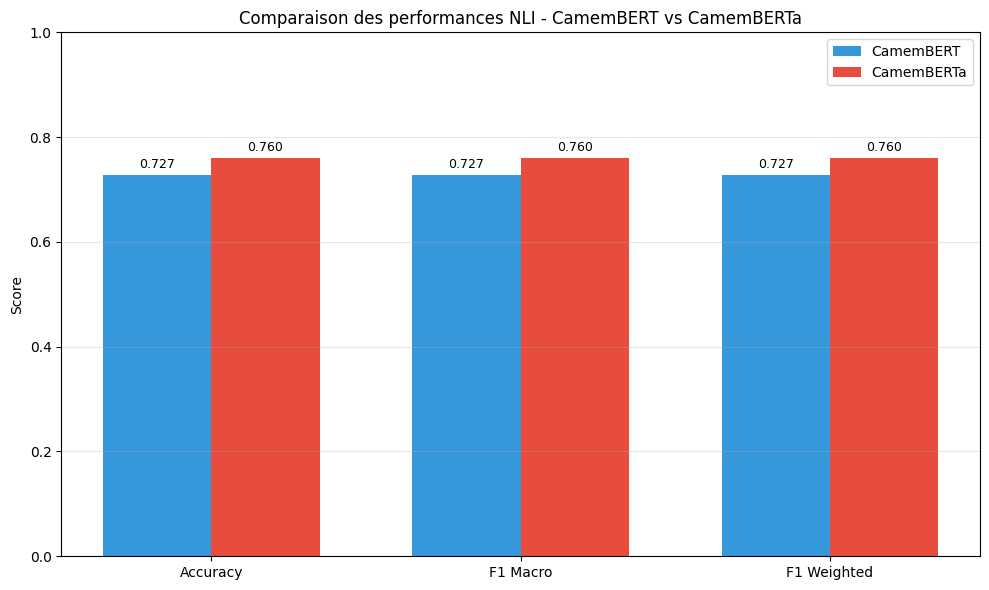


🏆 Meilleur modèle (F1 Macro): CamemBERTa


In [33]:
# Visualisation comparative
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(3)
width = 0.35

metrics = ['Accuracy', 'F1 Macro', 'F1 Weighted']
camembert_scores = [results_1['eval_accuracy'], results_1['eval_f1_macro'], results_1['eval_f1_weighted']]
camemberta_scores = [results_2['eval_accuracy'], results_2['eval_f1_macro'], results_2['eval_f1_weighted']]

bars1 = ax.bar(x - width/2, camembert_scores, width, label='CamemBERT', color='#3498db')
bars2 = ax.bar(x + width/2, camemberta_scores, width, label='CamemBERTa', color='#e74c3c')

ax.set_ylabel('Score')
ax.set_title('Comparaison des performances NLI - CamemBERT vs CamemBERTa')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

# Valeurs sur les barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Déterminer le gagnant
winner = "CamemBERT" if results_1['eval_f1_macro'] > results_2['eval_f1_macro'] else "CamemBERTa"
print(f"\n🏆 Meilleur modèle (F1 Macro): {winner}")

In [34]:
# Sélection du meilleur modèle
if results_1['eval_f1_macro'] > results_2['eval_f1_macro']:
    best_model = model_1
    best_tokenizer = tokenizer_1
    best_name = "CamemBERT"
    best_results = results_1
else:
    best_model = model_2
    best_tokenizer = tokenizer_2
    best_name = "CamemBERTa"
    best_results = results_2

print(f"Meilleur modèle: {best_name}")
print(f"   F1 Macro: {best_results['eval_f1_macro']:.4f}")
print(f"   Accuracy: {best_results['eval_accuracy']:.4f}")

# Sauvegarde
SAVE_PATH = "./best_model_nli_fr"
best_model.save_pretrained(SAVE_PATH)
best_tokenizer.save_pretrained(SAVE_PATH)
print(f"Modèle sauvegardé dans {SAVE_PATH}")

Meilleur modèle: CamemBERTa
   F1 Macro: 0.7598
   Accuracy: 0.7598
Modèle sauvegardé dans ./best_model_nli_fr


---

## 9. Inférence

In [38]:
def predict_nli(premise: str, hypothesis: str, model, tokenizer):
    """
    Prédit la relation NLI entre une prémisse et une hypothèse.
    
    Returns:
        dict avec 'prediction' et 'probabilities'
    """
    model.eval()
    device = next(model.parameters()).device
    
    inputs = tokenizer(
        premise, 
        hypothesis, 
        return_tensors="pt", 
        truncation=True, 
        max_length=MAX_LENGTH,
        padding=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probs, dim=-1).item()
    
    return {
        "prediction": ID2LABEL[prediction],
        "confidence": probs[0][prediction].item(),
        "probabilities": {
            ID2LABEL[i]: prob.item()
            for i, prob in enumerate(probs[0])
        }
    }


def display_prediction(premise: str, hypothesis: str, model, tokenizer):
    """Affiche joliment une prédiction."""
    result = predict_nli(premise, hypothesis, model, tokenizer)
    
    print(f"   Prémisse: {premise}")
    print(f"   Hypothèse: {hypothesis}")
    print(f"\n  Prédiction: {result['prediction'].upper()} (confiance: {result['confidence']:.1%})")
    print(f"\n  Probabilités:")
    for label, prob in result['probabilities'].items():
        bar = '█' * int(prob * 20)
        print(f"   {label:15} {bar} {prob:.1%}")
    print("-" * 60)

In [41]:
# Exemples de test
test_examples = [
    # Entailment (l'hypothèse découle de la prémisse)
    ("Je suis étudiant en Master MIASHS à Lyon 2.", "Je fais des études supérieures."),
    ("J'habite à Lyon.", "Je vis en Europe."),
    
    # Contradiction (l'hypothèse contredit la prémisse)
    ("Je suis en Master 2.", "Je suis en première année de licence."),
    ("J'habite à Lyon.", "J'habite à Marseille."),
    
    # Neutral (pas de lien logique direct)
    ("Je fais le Master MIASHS.", "Je joue la guitarre."),
    ("J'aime le rock", "Je prends le tram tout les matins"),
]

print("\nEXEMPLES DE PRÉDICTION")
print("=" * 60)

for premise, hypothesis in test_examples:
    display_prediction(premise, hypothesis, best_model, best_tokenizer)
    print()


EXEMPLES DE PRÉDICTION
   Prémisse: Je suis étudiant en Master MIASHS à Lyon 2.
   Hypothèse: Je fais des études supérieures.

  Prédiction: ENTAILMENT (confiance: 96.4%)

  Probabilités:
   entailment      ███████████████████ 96.4%
   neutral          2.5%
   contradiction    1.0%
------------------------------------------------------------

   Prémisse: J'habite à Lyon.
   Hypothèse: Je vis en Europe.

  Prédiction: NEUTRAL (confiance: 78.0%)

  Probabilités:
   entailment       3.2%
   neutral         ███████████████ 78.0%
   contradiction   ███ 18.8%
------------------------------------------------------------

   Prémisse: Je suis en Master 2.
   Hypothèse: Je suis en première année de licence.

  Prédiction: CONTRADICTION (confiance: 96.2%)

  Probabilités:
   entailment       1.6%
   neutral          2.2%
   contradiction   ███████████████████ 96.2%
------------------------------------------------------------

   Prémisse: J'habite à Lyon.
   Hypothèse: J'habite à Marseille.

 

---

## 10. Conclusion

### Résumé des résultats

Ce notebook a comparé deux modèles BERT français pour la tâche NLI avec fine-tuning LoRA :

| Modèle | Architecture | Accuracy | F1 Macro | F1 Weighted | Paramètres entraînés |
|--------|--------------|----------|----------|-------------|----------------------|
| **CamemBERT-base** | RoBERTa | 75.50% | 75.50% | 75.48% | 0.26% (~295k) |
| **CamemBERTa-base** | DeBERTa-v2 | **75.98%** | **75.98%** | **75.97%** | 0.26% (~297k) |

🏆 **Meilleur modèle : CamemBERTa** avec un F1 Macro de **75.98%**

### Analyse des performances

Les deux modèles obtiennent des performances très proches (~0.5% d'écart), mais CamemBERTa prend l'avantage grâce à son architecture DeBERTa-v2 qui intègre le *disentangled attention mechanism*.

L'early stopping s'est déclenché pour les deux modèles (epoch 6-7 sur 10), indiquant une convergence rapide et efficace avec LoRA.

### Points clés techniques

- **Polars** pour un chargement de données rapide, contournant les problèmes de compatibilité `pyarrow`/`datasets`
- **Dataset PyTorch custom** pour une intégration flexible avec le Trainer HuggingFace
- **LoRA (r=8, α=32)** : seulement ~0.26% des paramètres entraînés, permettant un fine-tuning sur GPU T4 (16 Go)
- **Early stopping (patience=3)** pour prévenir l'overfitting

### Limites observées

Lors des tests d'inférence, le modèle montre des difficultés sur :
- Le **raisonnement multi-étapes** : "J'habite à Lyon" → "Je vis en Europe" prédit comme Neutral (alors que c'est un Entailment via Lyon → France → Europe)
- Les cas **Neutral ambigus** avec confiance modérée (~57-73%)

### Pistes d'amélioration

1. **Augmenter le rang LoRA** (`r=16` ou `r=32`) pour plus de capacité
2. **Ajouter `key_proj`** aux target_modules de CamemBERTa
3. **Learning rate scheduler** avec warmup pour une convergence plus stable
4. **Data augmentation** (back-translation, paraphrase) pour enrichir le dataset
5. **Ensemble** des deux modèles pour combiner leurs forces
6. **Entraînement sur données géographiques** pour améliorer le raisonnement spatial